In [1]:
import dataset_utils as dataset

import torch as t

from ML_cup.pytorch import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#column_names = ['ID', 
#                'INPUT_1', 'INPUT_2', 'INPUT_3', 'INPUT_4', 'INPUT_5', 'INPUT_6', 'INPUT_7', 'INPUT_8', 'INPUT_9', 'INPUT_10',
#                'TARGET_x', 'TARGET_y', 'TARGET_z']
#dataframe = pd.read_csv("../data/ML-CUP23-TR.csv", sep=',', comment='#', names=column_names, index_col= 'ID')
#dataframe.head()

dev_data = dataset.load_dataset("../data/ML-CUP23-TR.csv")
blind_data = dataset.load_dataset("../data/ML-CUP23-TS.csv")

# arange the dataset into inputs and labels
from dataset_utils import arange_datasets, train_val_kfold

X_dev, y_dev, X_blind = arange_datasets(dev_data, blind_data)
train_folds, val_folds = train_val_kfold(X_dev, y_dev, folds=5, random_state= 42)

In [2]:
# Split the dev data into train and validation with k-fold cross validation and minibatch
train_loaders, val_loaders = dataset.torch_k_fold(dataset=dev_data, folds=5, batch_size=32)

In [3]:
parameters = [
    {'optimizer': 'SGD', 'lr': [0.01, 0.001, 0.0001], 'weight_decay': [0.0, 0.001, 0.0005], 'momentum': [0.9, 0.75],
     'nesterov': [True, False]}
]
lr_scheduler_params = {'mode': 'min', 'factor': 0.75, 'patience': 5, 'cooldown': 3, 'verbose': False, 'min_lr': 1e-6}
# perform grid search to find the best parameters
best_pytorch_params = grid_search(model_builder=MLP, parameters=parameters, train_loader=train_loaders,
                                  val_loader=val_loaders, scheduler=('ReduceLROnPlateau', lr_scheduler_params),
                                  verbose=False)

New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 4.373717401638627, Val Loss: 12.372602156230382
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.13867358192801477, Val Loss: 2.0727210249219623
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.03004763964563608, Val Loss: 0.6364766897899765
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.0, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.03217992556840182, Val Loss: 0.4216793069882052
New Best Parameters: {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'},Train Loss: 0.035040721781551834, Val Loss: 0.37276980366025647
New Best Parameters: {'lr': 0.001, 'weight_decay': 0.0, 'momentum': 0.9, 'nesterov': True, 'optimizer': 'SGD'},Train Loss: 0.1302573

Fold: 0
Train Epoch: 0 Loss: 192.45545654296876 Val Loss: 34.237589427403044
Train Epoch: 1 Loss: 23.094989204406737 Val Loss: 13.315831320626396
Train Epoch: 2 Loss: 10.90327558517456 Val Loss: 7.698510306222098
Train Epoch: 3 Loss: 6.2227515745162965 Val Loss: 3.4456801414489746
Train Epoch: 4 Loss: 3.573634395599365 Val Loss: 2.821599108832223
Train Epoch: 5 Loss: 2.5008637619018557 Val Loss: 2.634127616882324
Train Epoch: 6 Loss: 1.8720476913452149 Val Loss: 1.7806044135774886
Train Epoch: 7 Loss: 1.3102078700065614 Val Loss: 1.135563748223441
Train Epoch: 8 Loss: 0.9224623477458954 Val Loss: 1.0925532920019967
Train Epoch: 9 Loss: 0.8429456114768982 Val Loss: 0.851025904927935
Train Epoch: 10 Loss: 0.7264961421489715 Val Loss: 1.059431186744145
Train Epoch: 11 Loss: 0.5535832011699676 Val Loss: 0.6844489191259656
Train Epoch: 12 Loss: 0.482541977763176 Val Loss: 0.5976709319012505
Train Epoch: 13 Loss: 0.4567868709564209 Val Loss: 0.6975450473172324
Train Epoch: 14 Loss: 0.4390393

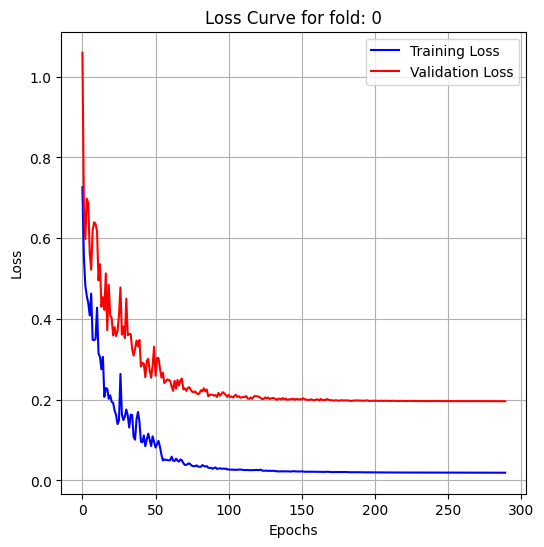

(0.0192274684458971, 0.1963781751692295)

In [6]:

best_pytorch_params = {'lr': 0.01, 'weight_decay': 0.001, 'momentum': 0.75, 'nesterov': False, 'optimizer': 'SGD'}
# retrain the model with the best parameters
best_model = MLP()
train_loader, val_loader = dataset.torch_split_dataset(dataset=dev_data, train_ratio=0.8, batch_size=32)
if best_pytorch_params['optimizer'] == 'SGD':
    optimizer = t.optim.SGD(best_model.parameters(), lr=best_pytorch_params['lr'],
                            weight_decay=best_pytorch_params['weight_decay'], momentum=best_pytorch_params['momentum'],
                            nesterov=best_pytorch_params['nesterov'])
else:
    optimizer = t.optim.Adam(best_model.parameters(), lr=best_pytorch_params['lr'],
                             weight_decay=best_pytorch_params['weight_decay'])

torch_train(model=best_model, optimizer=optimizer, train_loader=train_loader,
            val_loader=val_loader, epochs=300,
            verbose=True,
            scheduler=lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, cooldown=3,
                                                     verbose=True, min_lr=1e-6))

In [5]:
'''test_loader = DataLoader(CupDataset(blind_data))

# plot twist, it's only the inputs

# Evaluate the trained model on the test set
model = best_model
model.eval()  # Set the model to evaluation mode

outputs = []
with torch.no_grad():
    for inputs, labels in test_loader:
        output = model(inputs)
        outputs.append(output)

outputs'''

"test_loader = DataLoader(CupDataset(blind_data))\n\n# plot twist, it's only the inputs\n\n# Evaluate the trained model on the test set\nmodel = best_model\nmodel.eval()  # Set the model to evaluation mode\n\noutputs = []\nwith torch.no_grad():\n    for inputs, labels in test_loader:\n        output = model(inputs)\n        outputs.append(output)\n\noutputs"